In [114]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

In [156]:
n_genotypes = 86

means = np.random.exponential(scale=1, size=n_genotypes)
sds = np.random.random(size=n_genotypes) * 3
num_measurements = np.random.randint(low=2, high=8, size=n_genotypes)

# Create simulated data.
data = []
indices = []

for i in range(n_genotypes):
    n = num_measurements[i]
    mean = means[i]
    sd = sds[i]
    
    measurements = np.random.normal(loc=mean, scale=sd, size=n)
    
    data.extend(measurements.tolist())
    indices.extend([i] * n)

In [157]:
len(data), len(indices)

(382, 382)

In [158]:
with pm.Model() as model:
    
#     mus = pm.Flat('mus')
#     sds = pm.HalfCauchy('sds', beta=1)
#     lam = pm.HalfCauchy('lam', beta=1)

#     mu1 = pm.Normal('mu1', mu=mus, sd=sds)
#     sd1 = pm.Exponential('sd1', lam=lam)
#     mu2 = pm.Normal('mu2', mu=mus, sd=sds)
#     sd2 = pm.Exponential('sd2', lam=lam)
#     mu3 = pm.Normal('mu3', mu=mus, sd=sds)
#     sd3 = pm.Exponential('sd3', lam=lam)
#     geno1_like = pm.Normal('geno1', mu=mu1, sd=sd1, observed=geno1_folds)
#     geno2_like = pm.Normal('geno2', mu=mu2, sd=sd2, observed=geno2_folds)
#     geno3_like = pm.Normal('geno3', mu=mu3, sd=sd3, observed=geno3_folds)

    # --- try alternate implementation --- #
    # Hyperpriors
    mu_a = pm.Exponential('mu_a', lam=1)
    sigma_a = pm.HalfCauchy('sigma_a', 5)

    # Slope and intercept
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_genotypes)
    a = pm.Exponential('a', lam=mu_a, shape=n_genotypes)
    
    # Error
    sigma = pm.Gamma('sigma', alpha=1, beta=1)
    
    # Model prediction
    mu = a[indices]
    
    # Data likelihood
    like = pm.Normal('like', mu=mu, sd=sigma, observed=data)

Applied log-transform to mu_a and added transformed mu_a_log_ to model.
Applied log-transform to sigma_a and added transformed sigma_a_log_ to model.
Applied log-transform to a and added transformed a_log_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [159]:
with model:
    params = pm.variational.advi(n=200000)
    trace = pm.variational.sample_vp(params, draws=2000)

Iteration 0 [0%]: ELBO = -947.51
Iteration 20000 [10%]: Average ELBO = -1346.67
Iteration 40000 [20%]: Average ELBO = -860.92
Iteration 60000 [30%]: Average ELBO = -861.41
Iteration 80000 [40%]: Average ELBO = -861.15
Iteration 100000 [50%]: Average ELBO = -861.84
Iteration 120000 [60%]: Average ELBO = -862.17
Iteration 140000 [70%]: Average ELBO = -861.39
Iteration 160000 [80%]: Average ELBO = -860.18
Iteration 180000 [90%]: Average ELBO = -861.92
Finished [100%]: Average ELBO = -861.14


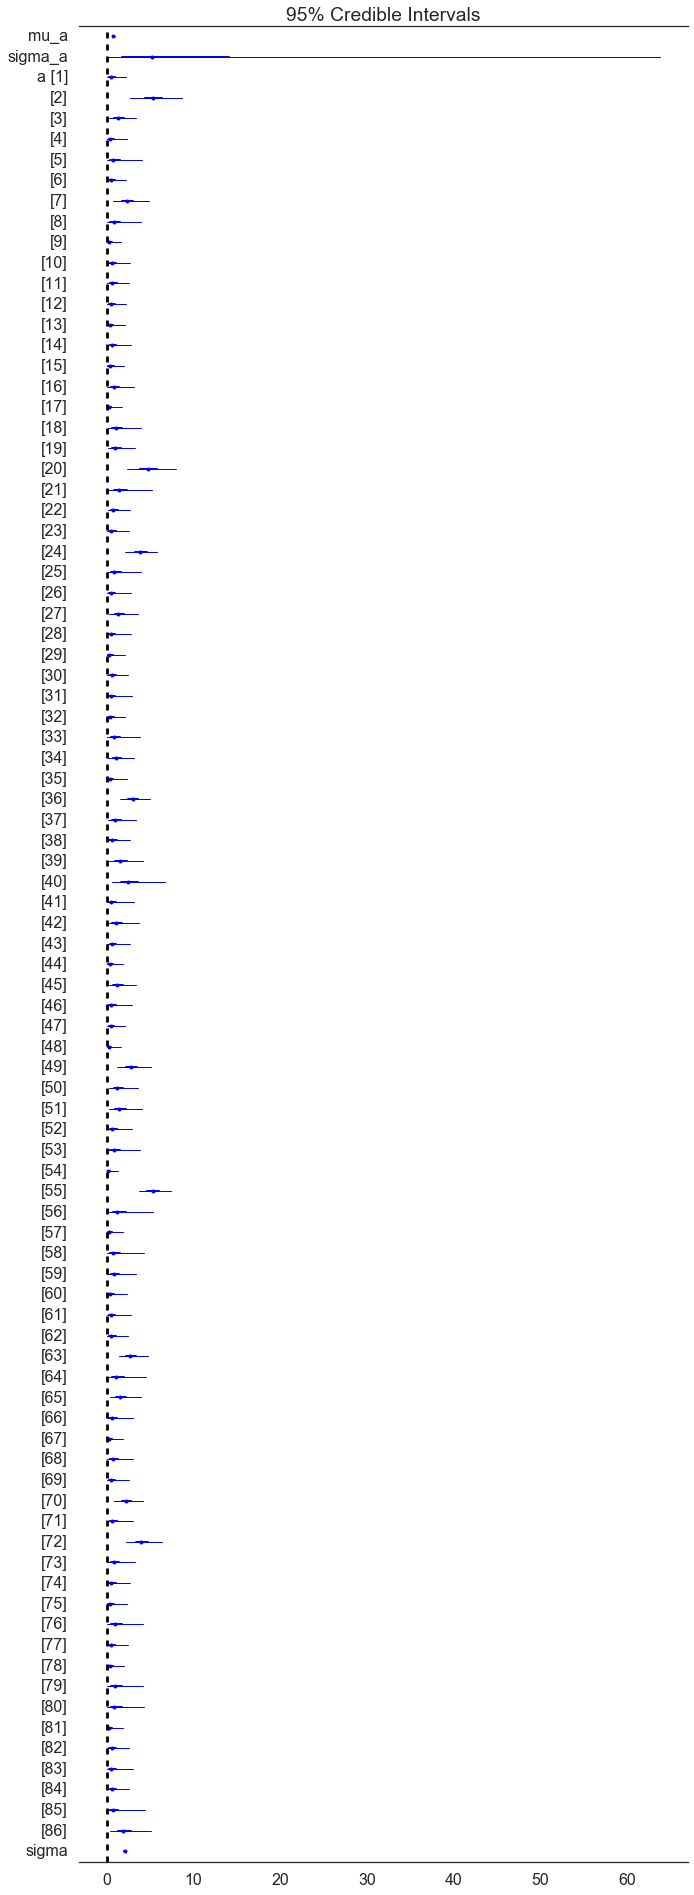

In [168]:
fig = plt.figure(figsize=(10, 30))
pm.forestplot(trace)

In [161]:
pm.summary(trace)


mu_a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.726            0.090            0.002            [0.566, 0.917]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.564          0.663          0.720          0.784          0.916


sigma_a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  15.482           38.412           0.844            [0.034, 63.755]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.298          1.785          5.191          14.116         89.226


a:

  Mean             SD               MC Error         95% HPD interval
  --------------------------

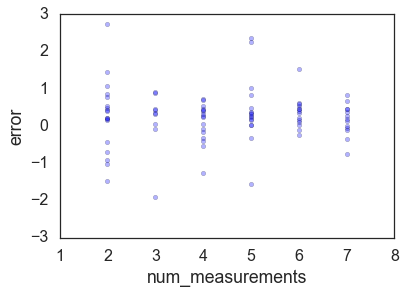

In [162]:
plt.scatter(num_measurements, (trace['a'].mean(axis=0) - means), alpha=0.3)
plt.xlabel('num_measurements')
plt.ylabel('error')

In [163]:
(trace['a'].mean(axis=0) - means).var()

0.52292597546407793

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127ef11d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x127f5de10>]], dtype=object)

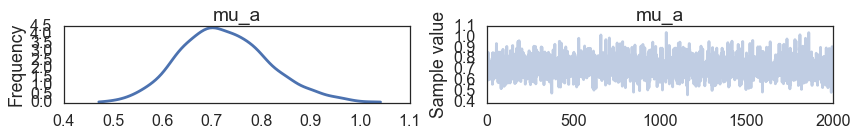

In [164]:
pm.traceplot(trace, varnames=['mu_a'])